### 필요한 모듈 불러오기
- sklearn
- 시간재는 함수

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

import sys
import time
_start_time = time.time()

def tic():
    global _start_time 
    _start_time = time.time()

def tac():
    t_sec = round(time.time() - _start_time)
    (t_min, t_sec) = divmod(t_sec,60)
    (t_hour,t_min) = divmod(t_min,60) 
    print('Time passed: {}hour:{}min:{}sec'.format(t_hour,t_min,t_sec))

### 데이터 정제 1단계
1. 한글 외의 문자 제거
2. 중복된 샘플 제거

In [2]:
import os
import pandas as pd
csv_path = os.getenv("HOME") + "/aiffel/news_crawler/news_data.csv"
df_1 = pd.read_table(csv_path, sep=',')
# df.head()

# 정규 표현식을 이용해서 한글 외의 문자는 전부 제거합니다.
df_1['news'] = df_1['news'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
df_1['news']

# 중복된 샘플들을 제거합니다.
df_1.drop_duplicates(subset=['news'], inplace=True)

print('뉴스 기사1의 개수: ',len(df_1))

csv_path_2 = os.getenv("HOME") + "/aiffel/news_crawler/news_data2.csv"
df_2 = pd.read_table(csv_path_2, sep=',')

# 정규 표현식을 이용해서 한글 외의 문자는 전부 제거합니다.
df_2['news'] = df_2['news'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
df_2['news']

# 중복된 샘플들을 제거합니다.
df_2.drop_duplicates(subset=['news'], inplace=True)

print('뉴스 기사2의 개수: ',len(df_2))

뉴스 기사1의 개수:  3994
뉴스 기사2의 개수:  2137


df_1의 분포


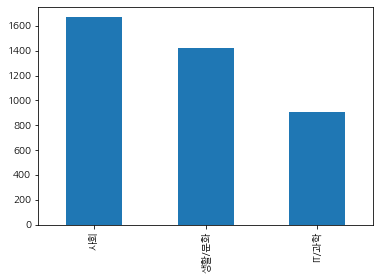

In [3]:
#import matplotlib as plt
#plt.rc('font', family='NanumGothic') 
import matplotlib as plt
plt.rc('font', family='NanumGothic') 
plt.rcParams['axes.unicode_minus'] = False
df_1['code'].value_counts().plot(kind = 'bar')
print('df_1의 분포')

df_2의 분포


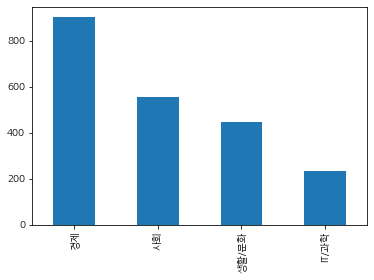

In [4]:
print('df_2의 분포')
df_2['code'].value_counts().plot(kind = 'bar')

# Step 1. 형태소 분석기 변경해 보기

[참조 url](https://konlpy.org/ko/v0.5.2/api/konlpy.tag)

- Hannanum Class
- Khma Class   
    There are reports that Kkma() is weak for long strings with no spaces between words.
- Komoran Class
- Mecab Class
- Okt Class

이들 형태소 분석기 중 어떤 것을 선택하는 것이 좋을지, 형태소 분석기간의 장단점은 무엇인지, 처리 속도와 성능에는 어떤 변화가 있는지 비교해 보세요.

 morphological analyzer : 형태소 분석기

In [5]:
from konlpy.tag import Hannanum, Kkma, Komoran, Mecab, Okt

hannanum_tokenizer = Hannanum()
kkma_tokenizer = Kkma()
komoran_tokenizer = Komoran()
mecab_tokenizer = Mecab()
okt_tokenizer = Okt()

tokenizers = {
    'hannanum' : hannanum_tokenizer,
    'kkma' : kkma_tokenizer,
    'komoran' : komoran_tokenizer,
    'mecab' : mecab_tokenizer,
    'okt' : okt_tokenizer,    
}

tokenizer_names = [
    'hannanum',
    'kkma',
    'komoran',
    'mecab',
    'okt', 
]

kor_text = '밤에 귀가하던 여성에게 범죄를 시도한 대 남성이 구속됐다서울 제주경찰서는 \
            상해 혐의로 씨를 구속해 수사하고 있다고 일 밝혔다씨는 지난달 일 피해 여성을 \
            인근 지하철 역에서부터 따라가 폭행을 시도하려다가 도망간 혐의를 받는다피해 \
            여성이 저항하자 놀란 씨는 도망갔으며 신고를 받고 주변을 수색하던 경찰에 \
            체포됐다피해 여성은 이 과정에서 경미한 부상을 입은 것으로 전해졌다'

#- 형태소 분석, 즉 토큰화(tokenization)를 합니다.
# print('============Hannanum===========')
# print(hannanum_tokenizer.morphs(kor_text))
# print('============Kkma===========')
# print(kkma_tokenizer.morphs(kor_text))
# print('============Komoran===========')
# print(komoran_tokenizer.morphs(kor_text))
# print('============Mecab===========')
# print(mecab_tokenizer.morphs(kor_text))
# print('============Okt===========')
# print(okt_tokenizer.morphs(kor_text))

# Step 2. 불용어 추가해 보기

In [23]:
# 기존 31개
stopwords_original = ['에','는','은','을','했','에게','있','이','의','하','한','다','과','때문','할','수','무단','따른','및','금지','전재','경향신문','기자','는데','가','등','들','파이낸셜','저작','등','뉴스']

# 추가하는 단어
stopwords_add = [
    '만','를','로다','랑','든','도','대로','까지',
    '고','에겐','거든','건','군','나','부','다면','던','되','려고']

stopwords_combined = stopwords_original + stopwords_add

print('stopwords len', len(stopwords_combined))

stopwords len 31


### 주어진 tokenizer, data 를 통해 전처리를 진행하고 걸린 시간을 알려주는 함수

In [24]:
# 토큰화 및 토큰화 과정에서 불용어를 제거하는 함수입니다.
def preprocess_with_time(selected_tokenizer = tokenizer_names[0], selected_data = df_1, stopwords= stopwords):
    tic()
    
    print('With {0} tokenizer, data len : {1}, stopword len : {2}'.format(selected_tokenizer, len(selected_data), len(stopwords)))
    tokenizer = tokenizers[selected_tokenizer]
    processed_text = []

    for idx,sentence in enumerate(selected_data['news']):        
        temp_data = []
        #- 토큰화
        temp_data = tokenizer.morphs(sentence) 
        #- 불용어 제거
        temp_data = [word for word in temp_data if not word in stopwords]
        processed_text.append(temp_data)
        if idx % 100 == 0:
            sys.stdout.write('\n')
            sys.stdout.flush()
        else:
            sys.stdout.write(".")
            sys.stdout.flush()

        # print('.', end = '')

    processed_text = list(map(' '.join, processed_text))

    tac()

    return processed_text

    

### CountVectorizer, TF-IDF transformer 및 TF-IDF vectorizer 준비

In [8]:
#- 단어의 수를 카운트하는 사이킷런의 카운트벡터라이저입니다.
count_vect = CountVectorizer()
#- 카운트벡터라이저의 결과로부터 TF-IDF 결과를 얻습니다.
tfidf_transformer = TfidfTransformer()

def tfidf_vectorizer(data):
  data_counts = count_vect.transform(data)
  data_tfidf = tfidf_transformer.transform(data_counts)
  return data_tfidf

### 훈련, 테스트 데이터 분류 및 모델 훈련 기능

In [25]:
def split_and_train(processed_text, selected_data = df_1):
    #- 훈련 데이터와 테스트 데이터를 분리합니다.
    X_train, X_test, y_train, y_test = train_test_split(processed_text, selected_data['code'], random_state = 0)

    print('훈련용 뉴스 기사의 개수 :', len(X_train))
    print('테스트용 뉴스 기사의 개수 : ', len(X_test))
    print('훈련용 레이블의 개수 : ', len(y_train))
    print('테스트용 레이블의 개수 : ', len(y_test))

    X_train_counts = count_vect.fit_transform(X_train)
    X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
    #- 나이브 베이즈 분류기를 수행합니다.
    #- X_train은 TF-IDF 벡터, y_train은 레이블입니다.
    clf = MultinomialNB().fit(X_train_tfidf, y_train)

    return X_train, X_test, y_train, y_test, clf

# Tokenizer 비교 실험
실험 데이터 : df_1(news_data.csv), df_2(news_data2.csv) 
- df_1
    - len : 3994
    - 기사 종류(code) 3가지(df_2에 비해 1가지 적음) 종류에 해당하는 데이터 수(기사 수) 의 분포가 df_2에 비해 고르다.
- df_2
    - len : 2137
    - 기사 종류(code) 4가지(df_1에 비해 1가지 많음) 종류에 해당하는 데이터 수(기사 수) 의 분포가 df_1에 비해 고르지 않다.

stopwords : stopwords_original(31개), stopwords_combined (50개)

## 1. Hannanum Tokenizer

### (1-1) df_1, stopwords_original 로 전처리

In [10]:
selected_tokenizer = tokenizer_names[0]
selected_data = df_1
stopwords = stopwords_original

processed_text_0= preprocess_with_time(selected_tokenizer,selected_data,stopwords)

X_train, X_test, y_train, y_test, clf = split_and_train(processed_text_0, selected_data)

y_pred = clf.predict(tfidf_vectorizer(X_test))
print('Result with {0} tokenizer on data len : {1}, stopwords len : {2}'.format(selected_tokenizer, len(selected_data), len(stopwords)))
print(metrics.classification_report(y_test, y_pred))


With hannanum tokenizer, data len : 3994, stopword len : 31

...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
.......................................

### (1-2) 훈련 및 예측

In [11]:
# X_train, X_test, y_train, y_test, clf = split_and_train(processed_text_0, selected_data)

# y_pred = clf.predict(tfidf_vectorizer(X_test))
# print('Result with {0} tokenizer on data len : {1}, stopwords len : {2}'.format(selected_tokenizer, len(selected_data), len(stopwords)))
# print(metrics.classification_report(y_test, y_pred))

### (2-1) df_2, stopwords_original 로 전처리

In [12]:
selected_tokenizer = tokenizer_names[0]
selected_data = df_2
stopwords = stopwords_original

processed_text_1= preprocess_with_time(selected_tokenizer,selected_data,stopwords)

X_train, X_test, y_train, y_test, clf = split_and_train(processed_text_1, selected_data)

y_pred = clf.predict(tfidf_vectorizer(X_test))
print('Result with {0} tokenizer on data len : {1}, stopwords len : {2}'.format(selected_tokenizer, len(selected_data), len(stopwords)))
print(metrics.classification_report(y_test, y_pred))

With hannanum tokenizer, data len : 2137, stopword len : 31

...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
.......................................

### (2-2) 훈련 및 예측

In [13]:
# X_train, X_test, y_train, y_test, clf = split_and_train(processed_text_1, selected_data)

# y_pred = clf.predict(tfidf_vectorizer(X_test))
# print('Result with {0} tokenizer on data len : {1}, stopwords len : {2}'.format(selected_tokenizer, len(selected_data), len(stopwords)))
# print(metrics.classification_report(y_test, y_pred))

## 2. Kkma Tokenizer

### (1-1) df_1,stopwords_original 로 전처리

In [26]:
selected_tokenizer = tokenizer_names[1]
selected_data = df_1
stopwords = stopwords_original

processed_text_2= preprocess_with_time(selected_tokenizer,selected_data,stopwords)

X_train, X_test, y_train, y_test, clf = split_and_train(processed_text_2, selected_data)

y_pred = clf.predict(tfidf_vectorizer(X_test))
print('Result with {0} tokenizer on data len : {1}, stopwords len : {2}'.format(selected_tokenizer, len(selected_data), len(stopwords)))
print(metrics.classification_report(y_test, y_pred))

With kkma tokenizer, data len : 3994, stopword len : 31

...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...........................................

### (1-2) 훈련 및 예측

In [ ]:
# X_train, X_test, y_train, y_test, clf = split_and_train(processed_text_2, selected_data)

# y_pred = clf.predict(tfidf_vectorizer(X_test))
# print('Result with {0} tokenizer on data len : {1}, stopwords len : {2}'.format(selected_tokenizer, len(selected_data), len(stopwords)))
# print(metrics.classification_report(y_test, y_pred))

### (2-1) df_2, stopwords_original 로 전처리

In [21]:
selected_tokenizer = tokenizer_names[1]
selected_data = df_2
stopwords = stopwords_original

processed_text_3= preprocess_with_time(selected_tokenizer,selected_data,stopwords)

X_train, X_test, y_train, y_test, clf = split_and_train(processed_text_3, selected_data)

y_pred = clf.predict(tfidf_vectorizer(X_test))
print('Result with {0} tokenizer on data len : {1}, stopwords len : {2}'.format(selected_tokenizer, len(selected_data), len(stopwords)))
print(metrics.classification_report(y_test, y_pred))

With kkma tokenizer, data len : 2137, stopword len : 31

...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...........................................

### (2-2) 훈련 및 예측

In [ ]:
# X_train, X_test, y_train, y_test, clf = split_and_train(processed_text_3, selected_data)

# y_pred = clf.predict(tfidf_vectorizer(X_test))
# print('Result with {0} tokenizer on data len : {1}, stopwords len : {2}'.format(selected_tokenizer, len(selected_data), len(stopwords)))
# print(metrics.classification_report(y_test, y_pred))

## 3. Komoran Tokenizer

### (1-1) df_1, stopwords_original 로 전처리

In [94]:
selected_tokenizer = tokenizer_names[2]
selected_data = df_1
stopwords = stopwords_original

processed_text_4= preprocess_with_time(selected_tokenizer,selected_data,stopwords)

X_train, X_test, y_train, y_test, clf = split_and_train(processed_text_4, selected_data)

y_pred = clf.predict(tfidf_vectorizer(X_test))
print('Result with {0} tokenizer on data len : {1}, stopwords len : {2}'.format(selected_tokenizer, len(selected_data), len(stopwords)))
print(metrics.classification_report(y_test, y_pred))

With komoran tokenizer, data len : 3994, stopword len : 31
..

### (1-2) 훈련 및 예측

In [ ]:
# X_train, X_test, y_train, y_test, clf = split_and_train(processed_text_4, selected_data)

# y_pred = clf.predict(tfidf_vectorizer(X_test))
# print('Result with {0} tokenizer on data len : {1}, stopwords len : {2}'.format(selected_tokenizer, len(selected_data), len(stopwords)))
# print(metrics.classification_report(y_test, y_pred))

### (2-1) df_2, stopwords_original 로 전처리

In [95]:
selected_tokenizer = tokenizer_names[2]
selected_data = df_2
stopwords = stopwords_original

processed_text_5= preprocess_with_time(selected_tokenizer,selected_data,stopwords)

X_train, X_test, y_train, y_test, clf = split_and_train(processed_text_5, selected_data)

y_pred = clf.predict(tfidf_vectorizer(X_test))
print('Result with {0} tokenizer on data len : {1}, stopwords len : {2}'.format(selected_tokenizer, len(selected_data), len(stopwords)))
print(metrics.classification_report(y_test, y_pred))

With komoran tokenizer, data len : 2137, stopword len : 31
..

### (2-2) 훈련 및 예측

In [ ]:
# X_train, X_test, y_train, y_test, clf = split_and_train(processed_text_5, selected_data)

# y_pred = clf.predict(tfidf_vectorizer(X_test))
# print('Result with {0} tokenizer on data len : {1}, stopwords len : {2}'.format(selected_tokenizer, len(selected_data), len(stopwords)))
# print(metrics.classification_report(y_test, y_pred))

## 4. Mecab Tokenizer

### (1-1) df_1, stopwords_original 로 전처리

In [ ]:
selected_tokenizer = tokenizer_names[3]
selected_data = df_1
stopwords = stopwords_original

processed_text_6= preprocess_with_time(selected_tokenizer,selected_data,stopwords)

X_train, X_test, y_train, y_test, clf = split_and_train(processed_text_6, selected_data)

y_pred = clf.predict(tfidf_vectorizer(X_test))
print('Result with {0} tokenizer on data len : {1}, stopwords len : {2}'.format(selected_tokenizer, len(selected_data), len(stopwords)))
print(metrics.classification_report(y_test, y_pred))

### (1-2) 훈련 및 예측

In [ ]:
# X_train, X_test, y_train, y_test, clf = split_and_train(processed_text_6, selected_data)

# y_pred = clf.predict(tfidf_vectorizer(X_test))
# print('Result with {0} tokenizer on data len : {1}, stopwords len : {2}'.format(selected_tokenizer, len(selected_data), len(stopwords)))
# print(metrics.classification_report(y_test, y_pred))

### (2-1) df_2, stopwords_original 로 전처리

In [ ]:
selected_tokenizer = tokenizer_names[3]
selected_data = df_2
stopwords = stopwords_original

processed_text_7= preprocess_with_time(selected_tokenizer,selected_data,stopwords)

X_train, X_test, y_train, y_test, clf = split_and_train(processed_text_7, selected_data)

y_pred = clf.predict(tfidf_vectorizer(X_test))
print('Result with {0} tokenizer on data len : {1}, stopwords len : {2}'.format(selected_tokenizer, len(selected_data), len(stopwords)))
print(metrics.classification_report(y_test, y_pred))

### (2-2) 훈련 및 예측

In [ ]:
# X_train, X_test, y_train, y_test, clf = split_and_train(processed_text_7, selected_data)

# y_pred = clf.predict(tfidf_vectorizer(X_test))
# print('Result with {0} tokenizer on data len : {1}, stopwords len : {2}'.format(selected_tokenizer, len(selected_data), len(stopwords)))
# print(metrics.classification_report(y_test, y_pred))

## 5. Oky Tokenizer

### (1-1) df_1, stopwords_original 로 전처리

In [ ]:
selected_tokenizer = tokenizer_names[4]
selected_data = df_1
stopwords = stopwords_original

processed_text_8= preprocess_with_time(selected_tokenizer,selected_data,stopwords)

X_train, X_test, y_train, y_test, clf = split_and_train(processed_text_8, selected_data)

y_pred = clf.predict(tfidf_vectorizer(X_test))
print('Result with {0} tokenizer on data len : {1}, stopwords len : {2}'.format(selected_tokenizer, len(selected_data), len(stopwords)))
print(metrics.classification_report(y_test, y_pred))

### (1-2) 훈련 및 예측

In [ ]:
# X_train, X_test, y_train, y_test, clf = split_and_train(processed_text_8, selected_data)

# y_pred = clf.predict(tfidf_vectorizer(X_test))
# print('Result with {0} tokenizer on data len : {1}, stopwords len : {2}'.format(selected_tokenizer, len(selected_data), len(stopwords)))
# print(metrics.classification_report(y_test, y_pred))

### (2-1) df_2, stopwords_original 로 전처리

In [ ]:
selected_tokenizer = tokenizer_names[4]
selected_data = df_2
stopwords = stopwords_original

processed_text_9= preprocess_with_time(selected_tokenizer,selected_data,stopwords)

X_train, X_test, y_train, y_test, clf = split_and_train(processed_text_9, selected_data)

y_pred = clf.predict(tfidf_vectorizer(X_test))
print('Result with {0} tokenizer on data len : {1}, stopwords len : {2}'.format(selected_tokenizer, len(selected_data), len(stopwords)))
print(metrics.classification_report(y_test, y_pred))

### (2-2) 훈련 및 예측

In [ ]:
# X_train, X_test, y_train, y_test, clf = split_and_train(processed_text_9, selected_data)

# y_pred = clf.predict(tfidf_vectorizer(X_test))
# print('Result with {0} tokenizer on data len : {1}, stopwords len : {2}'.format(selected_tokenizer, len(selected_data), len(stopwords)))
# print(metrics.classification_report(y_test, y_pred))

모든 형태소 분류기에 대해 stopwords_combined (주어진 불용어에 임의로 추가하여 50개로 만든 목록) 을 통한 전처리를 다시 진행하는 것은 상황상 어려울 것이라고 판단.  
(하나 전처리 하는데 20분씩 걸리기도 해서)
stopwords_original 에 대해 가장 좋은 결과를 보여주었던 형태소 분류기를 선정하여 stopwords_combined 를 통한 전처리를 한 데이터를 학습 및 예측한 결과를 산출.
기존의 결과와 비교한다.

## 가장 좋은 것으로 생각되는 경우

### <> Tokenizer
<이유>

그래서, 해당 Tokenizer 에 대해 결과가 더 좋았던 데이터셋 <df_1 or df_2> 에 대해 stopwords_combined 을 통한 전처리 및 학습,예측을 진행

In [ ]:
# num = 0

# selected_tokenizer = tokenizer_names[num]
# selected_data = df_1
# selected_data = df_2
# stopwords = stopwords_combined

# processed_text_10= preprocess_with_time(selected_tokenizer,selected_data,stopwords)

# X_train, X_test, y_train, y_test, clf = split_and_train(processed_text_10, selected_data)

# y_pred = clf.predict(tfidf_vectorizer(X_test))
# print('Result with {0} tokenizer on data len : {1}, stopwords len : {2}'.format(selected_tokenizer, len(selected_data), len(stopwords)))
# print(metrics.classification_report(y_test, y_pred))

# Step 3. 다른 날짜 데이터 추가해 보기

### url 가져오기

In [15]:
# 크롤러를 만들기 전 필요한 도구들을 임포트합니다.
import requests
import pandas as pd
from bs4 import BeautifulSoup
idx2word = {'101' : '경제', '102' : '사회', '103' : '생활/문화', '105' : 'IT/과학'}
# 페이지 수, 카테고리, 날짜를 입력값으로 받습니다.
def make_urllist(page_num, code, date): 
  urllist= []
  for i in range(1, page_num + 1):
    url = 'https://news.naver.com/main/list.nhn?mode=LSD&mid=sec&sid1='+str(code)+'&date='+str(date)+'&page='+str(i)   
    news = requests.get(url)

    # BeautifulSoup의 인스턴스 생성합니다. 파서는 html.parser를 사용합니다.
    soup = BeautifulSoup(news.content, 'html.parser')

    # CASE 1
    news_list = soup.select('.newsflash_body .type06_headline li dl')
    # CASE 2
    news_list.extend(soup.select('.newsflash_body .type06 li dl'))
        
    # 각 뉴스로부터 a 태그인 <a href ='주소'> 에서 '주소'만을 가져옵니다.
    for line in news_list:
        urllist.append(line.a.get('href'))
  return urllist

### url 에 해당하는 데이터를 받아와서 DataFrame 에 넣기 

In [17]:
from newspaper import Article

#- 데이터프레임을 생성하는 함수입니다.
def make_data(urllist, code):
  text_list = []
  for url in urllist:
    article = Article(url, language='ko')
    article.download()
    article.parse()
    text_list.append(article.text)

  #- 데이터프레임의 'news' 키 아래 파싱한 텍스트를 밸류로 붙여줍니다.
  df = pd.DataFrame({'news': text_list})

  #- 데이터프레임의 'code' 키 아래 한글 카테고리명을 붙여줍니다.
  df['code'] = idx2word[str(code)]
  return df

### idx2word dict 에 있는 모든 key 에 해당하는 기사들 가져오기

In [18]:
def make_total_data(page_num, idx2word, date):
    df = None
    for k,v in idx2word.items():
        url_list = make_urllist(page_num,k,date)
        df_temp = make_data(url_list, k)
        print(str(k)+'번 코드에 대한 데이터를 만들었습니다.')
        if df is not None:
            df = pd.concat([df, df_temp])
        else:
            df = df_temp

    return df

In [19]:
page_num = 10

date = 20200803
df_3 = make_total_data(page_num,idx2word,date)

csv_path = os.getenv("HOME") + "/aiffel/news_crawler/news_data_20200803.csv"
df_3.to_csv(csv_path, index=False)

if os.path.exists(csv_path):
  print('{} File Saved!'.format(csv_path))


AttributeError: 'dict' object has no attribute 'item'

### 새로 얻은 데이터 간단한 전처리 및 기존 데이터프레임에 합치기.

대부분의 형태소 분류기에서 데이터의 분포가 고른 경우 더 정확한 결과를 예측해내는 경향을 보였기 때문에,   
모델의 성능을 증가시키기 위해 종류(code)별 기사의 수를 균등하게 맞춰주는 방향으로 추가 데이터를 수집한다면 더 좋은 결과를 얻을 수 있을것으로 생각된다.

In [ ]:
# 한글 외 제거
df_3['news'] = df_3['news'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
df_3['news']

# 중복된 샘플들을 제거합니다.
df_3.drop_duplicates(subset=['news'], inplace=True)

df_4 = df_1.append(df_3)
df_5 = df_2.append(df_3)

In [ ]:
df_4['code'].value_counts().plot(kind = 'bar')
print('df_4의 분포')

In [ ]:
df_5['code'].value_counts().plot(kind = 'bar')
print('df_5의 분포')

### 2단계 실험에서 가장 성능이 좋았던 형태소 분류기 및 불용어 조합을 통한 전처리 및 학습*예측

- 대상 데이터 : <>
    대부분의 형태소 분류기에서 데이터의 분포가 고른 경우 더 정확한 결과를 예측해내는 경향을 보였기 때문에, 더 고른 데이터 분포를 보여주는 데이터셋 선택

In [ ]:
# num = 0

# selected_tokenizer = tokenizer_names[num]
# selected_data = df_1
# stopwords = stopwords_combined

# processed_text_10= preprocess_with_time(selected_tokenizer,selected_data,stopwords)

# X_train, X_test, y_train, y_test, clf = split_and_train(processed_text_10, selected_data)

# y_pred = clf.predict(tfidf_vectorizer(X_test))
# print('Result with {0} tokenizer on data len : {1}, stopwords len : {2}'.format(selected_tokenizer, len(selected_data), len(stopwords)))
# print(metrics.classification_report(y_test, y_pred))